## Clone ID Detection Attacks

## Members: Hassaan Jamil (i21-2774), Hadia Shahid (i21-1563), Maryam Shah (i21-1570) 

## Imports


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from collections import Counter
import torch
import torch.nn as nn
import torch.optim as optim



## Loading Dataset

In [2]:

# Load dataset
print("\n=== Loading Dataset ===")
df = pd.read_csv("Clone_ID.csv")
print("Initial dataset sample:")
print(df.head(3))
print(f"\nDataset shape: {df.shape}")


=== Loading Dataset ===
Initial dataset sample:
   PACKET_ID  SEGMENT_ID     PACKET_TYPE CONTROL_PACKET_TYPE/APP_NAME  \
0          0         0.0  Control_Packet                   OSPF_HELLO   
1          0         0.0  Control_Packet                   OSPF_HELLO   
2          0         NaN  Control_Packet                          DIO   

     SOURCE_ID DESTINATION_ID TRANSMITTER_ID  RECEIVER_ID  \
0  SINKNODE-17    Broadcast-0    SINKNODE-17    ROUTER-18   
1    ROUTER-18    Broadcast-0      ROUTER-18  SINKNODE-17   
2  SINKNODE-17    Broadcast-0    SINKNODE-17     SENSOR-5   

   APP_LAYER_ARRIVAL_TIME(US)  TRX_LAYER_ARRIVAL_TIME(US)  ...  isFin  \
0                         0.0                         0.0  ...    NaN   
1                         0.0                         0.0  ...    NaN   
2                         NaN                         NaN  ...    NaN   

   SEGMENT_LEN                                SOURCE_IP      DESTINATION_IP  \
0          NaN                           

## Basic Data Inspection

In [3]:

# 1. Basic Data Inspection
print("\n=== Data Inspection ===")
print("\nColumn types:")
print(df.dtypes)
print("\nMissing values:")
print(df.isnull().sum())


=== Data Inspection ===

Column types:
PACKET_ID                         int64
SEGMENT_ID                      float64
PACKET_TYPE                      object
CONTROL_PACKET_TYPE/APP_NAME     object
SOURCE_ID                        object
DESTINATION_ID                   object
TRANSMITTER_ID                   object
RECEIVER_ID                      object
APP_LAYER_ARRIVAL_TIME(US)      float64
TRX_LAYER_ARRIVAL_TIME(US)      float64
NW_LAYER_ARRIVAL_TIME(US)       float64
MAC_LAYER_ARRIVAL_TIME(US)      float64
PHY_LAYER_ARRIVAL_TIME(US)      float64
PHY_LAYER_START_TIME(US)        float64
PHY_LAYER_END_TIME(US)          float64
APP_LAYER_PAYLOAD(Bytes)        float64
TRX_LAYER_PAYLOAD(Bytes)        float64
NW_LAYER_PAYLOAD(Bytes)         float64
MAC_LAYER_PAYLOAD(Bytes)        float64
PHY_LAYER_PAYLOAD(Bytes)        float64
PHY_LAYER_OVERHEAD(Bytes)       float64
PACKET_STATUS                    object
LOCAL_ADDRESS                   float64
REMOTE_ADDRESS                  float64


## Visualize Missing Values

In [4]:

# Visualize missing values
missing_counts = df.isnull().sum()
print(missing_counts[missing_counts > 0])


SEGMENT_ID                     80993
APP_LAYER_ARRIVAL_TIME(US)     80993
TRX_LAYER_ARRIVAL_TIME(US)     80993
APP_LAYER_PAYLOAD(Bytes)       80993
TRX_LAYER_PAYLOAD(Bytes)       80993
PHY_LAYER_PAYLOAD(Bytes)           1
PHY_LAYER_OVERHEAD(Bytes)          1
PACKET_STATUS                      1
LOCAL_ADDRESS                 114837
REMOTE_ADDRESS                114837
CWND                          114837
SEQ_NO                        114837
ACK_NO                        114837
isSyn                         114837
isAck                         114837
isFin                         114837
SEGMENT_LEN                   114837
SOURCE_IP                          1
DESTINATION_IP                     1
GATEWAY_IP                         1
NEXT_HOP_IP                        1
PCKT_LABEL                         1
RPL_RANK                       12333
RPL_VERSION                    33845
Unnamed: 38                   114837
dtype: int64


## Feature Engineering - Time Features



In [5]:
df['mac_latency'] = df['MAC_LAYER_ARRIVAL_TIME(US)'] - \
    df['NW_LAYER_ARRIVAL_TIME(US)']
df['phy_processing_time'] = df['PHY_LAYER_END_TIME(US)'] - \
    df['PHY_LAYER_START_TIME(US)']
df['transit_time'] = df['PHY_LAYER_END_TIME(US)'] - \
    df['MAC_LAYER_ARRIVAL_TIME(US)']

## Feature Engineering - Packet Type

In [6]:
# B. Packet type features
print("\nCreating packet type features...")
df['IS_CONTROL_PACKET'] = df['PACKET_TYPE'].apply(lambda x: 1 if x == 'Control_Packet' else 0)
df['IS_DIO'] = df['CONTROL_PACKET_TYPE/APP_NAME'].apply(lambda x: 1 if x == 'DIO' else 0)
df['IS_OSPF_HELLO'] = df['CONTROL_PACKET_TYPE/APP_NAME'].apply(lambda x: 1 if x == 'OSPF_HELLO' else 0)
print("\nPacket type features value counts:")
print(df[['IS_CONTROL_PACKET', 'IS_DIO', 'IS_OSPF_HELLO']].apply(pd.Series.value_counts)) 


Creating packet type features...

Packet type features value counts:
   IS_CONTROL_PACKET  IS_DIO  IS_OSPF_HELLO
0              33531  110436         114537
1              81306    4401            300


## Feature Engineering - Network Features

In [7]:
# C. Network features
print("\nCreating network features...")
df['SAME_SRC_DEST'] = (df['SOURCE_ID'] == df['DESTINATION_ID']).astype(int)
df['IS_BROADCAST'] = df['DESTINATION_ID'].str.contains('Broadcast').fillna(0).astype(int)
print("\nNetwork features value counts:")
print(df[['SAME_SRC_DEST', 'IS_BROADCAST']].apply(pd.Series.value_counts))


Creating network features...

Network features value counts:
   SAME_SRC_DEST  IS_BROADCAST
0         113436        110130
1           1401          4707


## Feature Engineering - Payload Ratio

In [8]:
# D. Payload features
payload_cols = [col for col in df.columns if 'PAYLOAD' in col and 'Bytes' in col]
if len(payload_cols) >= 1 and 'PHY_LAYER_PAYLOAD(Bytes)' in df.columns:
    print(f"\nCreating payload ratio features from: {payload_cols}")
    for col in payload_cols:
        if col != 'PHY_LAYER_PAYLOAD(Bytes)':
            df[f'{col}_RATIO'] = np.where(
                df['PHY_LAYER_PAYLOAD(Bytes)'] == 0, 
                0, 
                df[col] / df['PHY_LAYER_PAYLOAD(Bytes)']
            )
    print("\nPayload ratio features statistics:")
    print(df[[f'{col}_RATIO' for col in payload_cols if col != 'PHY_LAYER_PAYLOAD(Bytes)']].describe())



Creating payload ratio features from: ['APP_LAYER_PAYLOAD(Bytes)', 'TRX_LAYER_PAYLOAD(Bytes)', 'NW_LAYER_PAYLOAD(Bytes)', 'MAC_LAYER_PAYLOAD(Bytes)', 'PHY_LAYER_PAYLOAD(Bytes)']

Payload ratio features statistics:
       APP_LAYER_PAYLOAD(Bytes)_RATIO  TRX_LAYER_PAYLOAD(Bytes)_RATIO  \
count                    33844.000000                    33844.000000   
mean                         0.583631                        0.590154   
std                          0.074798                        0.050407   
min                          0.000000                        0.480769   
25%                          0.602410                        0.602410   
50%                          0.602410                        0.602410   
75%                          0.602410                        0.602410   
max                          0.641026                        0.848485   

       NW_LAYER_PAYLOAD(Bytes)_RATIO  MAC_LAYER_PAYLOAD(Bytes)_RATIO  
count                  114836.000000                   1

## Column Cleanup

In [9]:
# === Drop Unwanted Columns (in-place) ===
columns_to_drop = [
    # Completely empty columns
    'LOCAL_ADDRESS', 'REMOTE_ADDRESS', 'CWND', 'SEQ_NO', 'ACK_NO',
    'isSyn', 'isAck', 'isFin', 'SEGMENT_LEN', 'Unnamed: 38',

    # High null percentage
    'SEGMENT_ID', 'APP_LAYER_ARRIVAL_TIME(US)', 'TRX_LAYER_ARRIVAL_TIME(US)',
    'APP_LAYER_PAYLOAD(Bytes)', 'TRX_LAYER_PAYLOAD(Bytes)',

    # Redundant identifiers
    'PACKET_ID', 'SOURCE_ID', 'DESTINATION_ID', 'TRANSMITTER_ID', 'RECEIVER_ID',
    'SOURCE_IP', 'DESTINATION_IP', 'GATEWAY_IP', 'NEXT_HOP_IP'
]
df.drop(columns=columns_to_drop, inplace=True)

# === Show Data ===
print("\nCleaned dataset sample:")
print(df.head())
print("\nRemaining columns:")
print(df.columns.tolist())



Cleaned dataset sample:
      PACKET_TYPE CONTROL_PACKET_TYPE/APP_NAME  NW_LAYER_ARRIVAL_TIME(US)  \
0  Control_Packet                   OSPF_HELLO                        0.0   
1  Control_Packet                   OSPF_HELLO                        0.0   
2  Control_Packet                          DIO                     6241.0   
3  Control_Packet                          DIO                     6241.0   
4  Control_Packet                          DIO                     6241.0   

   MAC_LAYER_ARRIVAL_TIME(US)  PHY_LAYER_ARRIVAL_TIME(US)  \
0                         0.0                         0.0   
1                         0.0                         0.0   
2                      6241.0                      6881.0   
3                      6241.0                      6881.0   
4                      6241.0                      6881.0   

   PHY_LAYER_START_TIME(US)  PHY_LAYER_END_TIME(US)  NW_LAYER_PAYLOAD(Bytes)  \
0                      5.12                   10.12              

In [7]:
if 'PCKT_LABEL' not in df.columns:
    raise ValueError("Target column 'PCKT_LABEL' is missing!")

In [10]:
print("\n=== Preparing Features and Target ===")
X = df.drop(columns=['PCKT_LABEL'])
y = df['PCKT_LABEL'].fillna(0).astype(int)

# === 7. Recalculate Column Types ===
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
print("Numerical columns:", numerical_cols)
print("Categorical columns:", categorical_cols)


=== Preparing Features and Target ===
Numerical columns: ['NW_LAYER_ARRIVAL_TIME(US)', 'MAC_LAYER_ARRIVAL_TIME(US)', 'PHY_LAYER_ARRIVAL_TIME(US)', 'PHY_LAYER_START_TIME(US)', 'PHY_LAYER_END_TIME(US)', 'NW_LAYER_PAYLOAD(Bytes)', 'MAC_LAYER_PAYLOAD(Bytes)', 'PHY_LAYER_PAYLOAD(Bytes)', 'PHY_LAYER_OVERHEAD(Bytes)', 'RPL_RANK', 'RPL_VERSION', 'mac_latency', 'phy_processing_time', 'transit_time', 'IS_CONTROL_PACKET', 'IS_DIO', 'IS_OSPF_HELLO', 'SAME_SRC_DEST', 'IS_BROADCAST', 'APP_LAYER_PAYLOAD(Bytes)_RATIO', 'TRX_LAYER_PAYLOAD(Bytes)_RATIO', 'NW_LAYER_PAYLOAD(Bytes)_RATIO', 'MAC_LAYER_PAYLOAD(Bytes)_RATIO']
Categorical columns: ['PACKET_TYPE', 'CONTROL_PACKET_TYPE/APP_NAME', 'PACKET_STATUS']


## Target Variable Distribution

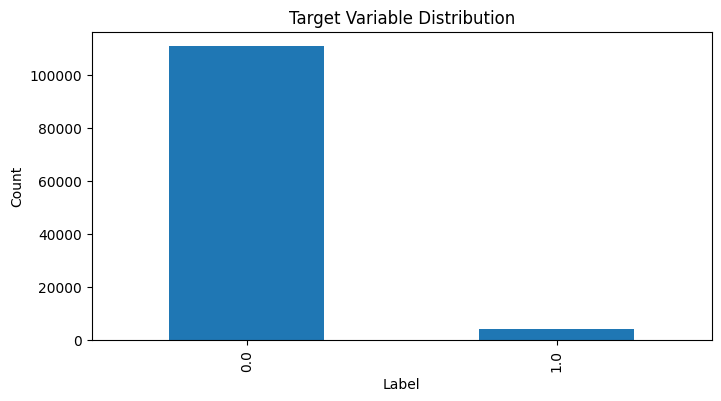

In [11]:
# === Visualize Target Distribution ===
plt.figure(figsize=(8, 4))
df['PCKT_LABEL'].value_counts().plot(kind='bar')
plt.title("Target Variable Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()


##  Preprocessing Pipelines

In [12]:
# === Preprocessing Pipelines ===
print("\n=== Preprocessing Setup ===")
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)



=== Preprocessing Setup ===


## Prepare X and Y 

## Train-Test Split

In [13]:
# === Train-Test Split ===
print("\n=== Train-Test Split ===")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(f"Train shapes: X={X_train.shape}, y={y_train.shape}")
print(f"Test shapes: X={X_test.shape}, y={y_test.shape}")


=== Train-Test Split ===
Train shapes: X=(80385, 26), y=(80385,)
Test shapes: X=(34452, 26), y=(34452,)


## Apply Pre-Processing

In [14]:
# === Apply Preprocessing ===
print("\n=== Preprocessing Data ===")
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)
print(f"Processed train shape: {X_train.shape}")
print(f"Processed test shape: {X_test.shape}")


=== Preprocessing Data ===
Processed train shape: (80385, 51)
Processed test shape: (34452, 51)


In [16]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

C:\Users\Hassaan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\Hassaan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.13_3.13.1008.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 554, in run


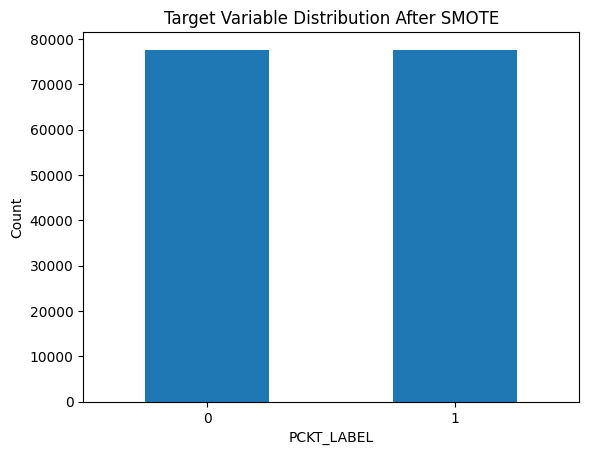

In [17]:
# Convert resampled labels to DataFrame for easier plotting
resampled_series = pd.Series(y_resampled, name='PCKT_LABEL')

# Plot the distribution
resampled_series.value_counts().sort_index().plot(kind='bar')
plt.title('Target Variable Distribution After SMOTE')
plt.xlabel('PCKT_LABEL')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

## XGBOOST

In [15]:
xgb_model = XGBClassifier(eval_metric='logloss')
xgb_model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

## RANDOM FOREST CLASSIFIER

In [18]:
# 8. Train model
print("\n=== Model Training ===")
model = RandomForestClassifier(n_estimators=150, 
                             class_weight='balanced',
                             random_state=42)
print("Training Random Forest model...")
model.fit(X_train, y_train)
print("Training completed!")


=== Model Training ===
Training Random Forest model...
Training completed!


## LOGISTIC REGRESSION


In [20]:
model = LogisticRegression()
model.fit(X_resampled,y_resampled)

C:\Users\Hassaan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

# Use CPU
device = torch.device("cpu")

# Encode labels if they are categorical
if y_train.dtype == 'O' or y_test.dtype == 'O':
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    y_test = le.transform(y_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.long).to(device)
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.long).to(device)

# Define the ANN model with dropout and multiple hidden layers
class ANNModel(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, dropout_prob=0.5):
        super().__init__()
        
        # First hidden layer
        self.fc1 = nn.Linear(input_dim, hidden_dims[0])
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_prob)
        
        # Additional hidden layers
        self.hidden_layers = nn.ModuleList()
        for i in range(1, len(hidden_dims)):
            self.hidden_layers.append(nn.Linear(hidden_dims[i-1], hidden_dims[i]))
            self.hidden_layers.append(nn.ReLU())
            self.hidden_layers.append(nn.Dropout(dropout_prob))  # Dropout for each hidden layer
        
        # Output layer
        self.fc_out = nn.Linear(hidden_dims[-1], output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        
        # Apply hidden layers
        for layer in self.hidden_layers:
            x = layer(x)
        
        # Output layer
        x = self.fc_out(x)
        return x

# Model setup
input_dim = X_train.shape[1]
hidden_dims = [128, 64, 32]  # Multiple hidden layers with different sizes
output_dim = len(set(y_train))

model = ANNModel(input_dim, hidden_dims, output_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 20
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")

# Evaluation
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)

accuracy = accuracy_score(y_test_tensor.cpu(), predicted.cpu())
report = classification_report(y_test_tensor.cpu(), predicted.cpu())

print(f"\n=== ANN Model Evaluation ===\nAccuracy: {accuracy:.4f}")
print("Classification Report:\n", report)


Epoch [5/20], Loss: 0.6227
Epoch [10/20], Loss: 0.5377
Epoch [15/20], Loss: 0.4290
Epoch [20/20], Loss: 0.3143

=== ANN Model Evaluation ===
Accuracy: 0.9635
Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98     33195
           1       0.00      0.00      0.00      1257

    accuracy                           0.96     34452
   macro avg       0.48      0.50      0.49     34452
weighted avg       0.93      0.96      0.95     34452



C:\Users\Hassaan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Hassaan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Hassaan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classi

## RESULT OF LOGISTIC REGRESSION

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# Train-test split or resampled data
# Assuming you already have: X_train, X_test, y_train, y_test

# Train model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# F1 Score (binary classification)
print("F1 Score:", f1_score(y_test, y_pred, average='binary'))  # For multiclass, use 'macro' or 'weighted'

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.9885347730175317
F1 Score: 0.8642145067033344
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     33195
           1       0.76      1.00      0.86      1257

    accuracy                           0.99     34452
   macro avg       0.88      0.99      0.93     34452
weighted avg       0.99      0.99      0.99     34452

Confusion Matrix:
 [[32800   395]
 [    0  1257]]


C:\Users\Hassaan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## RESULT OF XGBOOST

In [19]:
y_pred_xgb = xgb_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))


NameError: name 'xgb_model' is not defined

## RESULT OF RANDOM FOREST CLASSIFIER

In [20]:


# 9. Evaluation
print("\n=== Model Evaluation ===")
y_pred = model.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



=== Model Evaluation ===

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     33195
           1       0.84      0.79      0.82      1257

    accuracy                           0.99     34452
   macro avg       0.92      0.89      0.90     34452
weighted avg       0.99      0.99      0.99     34452



## Confusion Matrix

## Random Forest Classifier

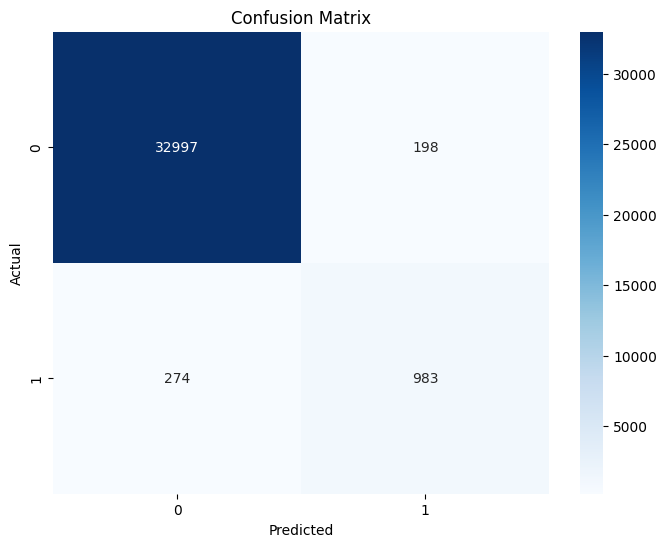

In [27]:

# Confusion matrix
plt.figure(figsize=(8,6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


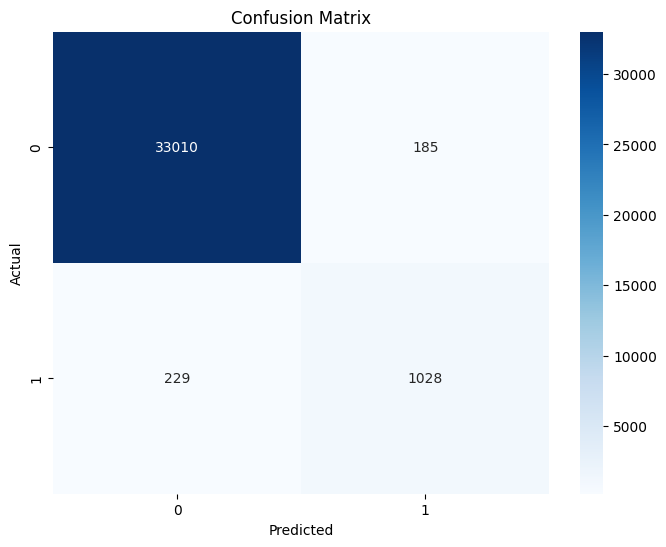

In [17]:

# Confusion matrix
plt.figure(figsize=(8,6))
cm = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


## ANN 


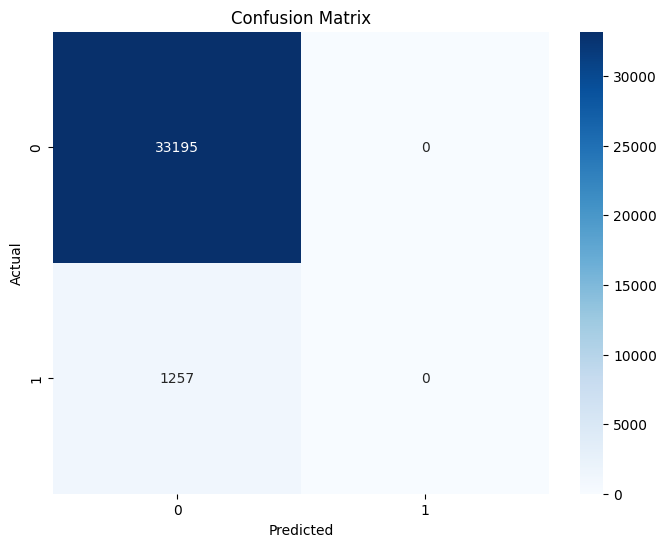

In [16]:
# Evaluation
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)

# Convert predictions and true labels to CPU if needed for confusion matrix
y_test_cpu = y_test_tensor.cpu()  # Actual labels
predicted_cpu = predicted.cpu()  # Predicted labels

# Generate confusion matrix
cm = confusion_matrix(y_test_cpu, predicted_cpu)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y_test_cpu), yticklabels=np.unique(y_test_cpu))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Feature Importance

In [17]:

# Feature importance
print("\n=== Feature Importance ===")
try:
    if hasattr(preprocessor, 'get_feature_names_out'):
        all_features = preprocessor.get_feature_names_out()
    else:
        num_features = numerical_cols
        if 'cat' in preprocessor.named_transformers_:
            cat_encoder = preprocessor.named_transformers_['cat'].named_steps['onehot']
            cat_features = cat_encoder.get_feature_names_out(categorical_cols)
            all_features = list(num_features) + list(cat_features)
        else:
            all_features = list(num_features)
    
    if len(all_features) == model.n_features_in_:
        feat_importances = pd.Series(model.feature_importances_, index=all_features)
        plt.figure(figsize=(10, 8))
        feat_importances.nlargest(20).plot(kind='barh')
        plt.title('Top 20 Important Features')
        plt.show()
        
        # Print top 10 features
        print("\nTop 10 Features:")
        print(feat_importances.nlargest(10))
    else:
        print(f"Feature name mismatch: Model has {model.n_features_in_} features, but we have {len(all_features)} names")
        plt.figure(figsize=(10, 6))
        pd.Series(model.feature_importances_).nlargest(20).plot(kind='barh')
        plt.title('Top 20 Important Features (unnamed)')
        plt.show()
except Exception as e:  
    print(f"Could not create feature importance plot: {str(e)}")

print("\n=== Process Completed ===")


=== Feature Importance ===
Could not create feature importance plot: 'ANNModel' object has no attribute 'n_features_in_'

=== Process Completed ===
